## ==================== Libraries ====================

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## <br><br><br>==================== Functions ====================

### Read Data

In [2]:
def readData(path):
    # Leer documento .csv.
    dfDistances = pandas.read_csv(path)
    
    # Obtener arreglo con nombres de los notos.
    nodeNames = dfDistances.values[:,0]
    
    # Obtener matriz de distancias.
    distancesMatrix = dfDistances.values[:,1:]
    
    # Crear diccionario.
    positionDict = {}
    
    # Rellenar diccionario.
    for i, node in enumerate(nodeNames):
        positionDict[node] = i
        
    return nodeNames, distancesMatrix, positionDict
    

### Objective Function

In [3]:
def objectiveFunction(nodeNames, distancesMatrix, positionDict, element):
    # Total de elementos.
    noNodes = len(nodeNames)
    
    # Checar si tiene la misma longitud.
    if( len(element) != noNodes+1 ):
        return -1
    
    # Checar si sí termina por donde comienza.
    if( element[0] != element[len(element)-1] ):
        return -1
    
    # Crear matriz de ceros.
    checkDistanceMatrix = np.zeros((noNodes, noNodes))
    
    # Distancia del elemento.
    distance = 0
    
    for i in range(len(element)):
        if( i+1 < len(element) ):    
            # Si el tramo del nodo i al nodo i+1 no se ha recorrido antes.
            if( checkDistanceMatrix[ positionDict[element[i]], positionDict[element[i+1]] ] == 0 or checkDistanceMatrix[ positionDict[element[i+1]], positionDict[element[i]] ] == 0 ):
                # Aumentar distancias.
                distance = distance + distancesMatrix[ positionDict[element[i]], positionDict[element[i+1]] ]
                
                # Marcar como tramo ya recorrido.
                checkDistanceMatrix[ positionDict[element[i]], positionDict[element[i+1]] ] = 1
                checkDistanceMatrix[ positionDict[element[i+1]], positionDict[element[i]] ] = 1
            else:
                return -1
            
    return distance

### <br><br><br><br>Genetic Algorithm

#### Selection functions

In [4]:
def parentsSelectionByTournament(k, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Matriz para guardar la población del torneo.
    newPopulation = np.zeros(k, dtype=int)

    # Rellenar matriz con nuevos individuos.
    for i in range(k):
        while True:
            # Generar número random.
            r = random.randint(0, N-1)
            
            # Si todavía no ha sido seleccionado dicho individuo.
            if r not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = r

                break
        
    # El mejor individuo.
    fittestIndividual = newPopulation[ np.argmin(populationFitness[newPopulation]) ]
    
    return fittestIndividual

In [5]:
def parentsSelectionByRoulette(k, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Lista para guardar las proporciones de cada individuo.
    proportionsRange = np.zeros((N,2))
    
    # Total suma de fitness.
    totalFitness = np.sum(populationFitness)
        
    # Calcular ruleta.
    roulette = np.cumsum(populationFitness / totalFitness)

    # Matriz para guardar la población de la ruleta.
    newPopulation = np.zeros(k, dtype=int)
    
    # Rellenar 
    for i in range(k):
        while True:
            # Generar un número random entre 0 y 1.
            randomNumber = np.random.uniform(0, 1, 1)

            # Checar qué rango es.
            j = 0
            while roulette[j] < randomNumber:
                j += 1
                
            # Si todavía no ha sido seleccionado dicho individuo.
            if j not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = j

                break
                    
    # El mejor individuo.
    fittestIndividual = newPopulation[ np.argmin(populationFitness[newPopulation]) ]
    
    return fittestIndividual

#### Crossover functions

In [6]:
def simpleCrossover(Pr, k, populationList, populationFitness, nodeNames, positionDict):
    # Obtener el tamaña de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            parent1 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            parent2 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent1 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            # parent2 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Dividir en partes a los papás.
            part1 = parent1[:len(parent1)//2]
            part2 = parent2[len(parent2)//2:]
            
            # Obtener al hijo.
            offspring = np.concatenate((part1,part2), axis=None)
            
            # Crear arreglo de zeros para checar cuáles faltan y cuáles nodos ya están.
            checkNodes = nodeNames.copy()
            checkNodes = np.array(checkNodes)
            
            # Crear arreglo de zeros para checar dónde se repiten las letras.
            repeatedNodes = []
            
            # Marcar nodos.
            for j in range(len(offspring)-1):
                if offspring[j] in checkNodes:
                    checkNodes[positionDict[offspring[j]]] = ''
                else:
                    repeatedNodes.append(j)
                    
            # Eliminar campos vacíos.
            checkNodes = checkNodes[checkNodes != '']
            
            # Aleatorizar el arreglo.
            random.shuffle(checkNodes)
            
            # Poner los nodos faltantes en los que están repetidos.
            for j,m in enumerate(repeatedNodes):
                offspring[m] = checkNodes[j]
                   
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Agregar a la población.      
            newPopulation[i] = parent
            
    return newPopulation
        

In [7]:
def partialCrossover(Pr, k, populationList, populationFitness, nodeNames, positionDict):
    # Obtener el tamaña de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            # parent1 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent2 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            parent1 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            parent2 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Obtener la división
            exactDivision = len(parent1)//3
            
            # Dividir en partes a los papás.
            part1 = parent2[:exactDivision]
            part2 = parent1[exactDivision:exactDivision*2]
            part3 = parent2[exactDivision*2:]
            part4 = parent2[exactDivision:exactDivision*2]
            
            # Crear arreglo donde irá el offspring.
            offspring = np.empty((len(parent1)), dtype=str)
            
            # Copiar elementos del primer padre.
            for j,m in enumerate(range(exactDivision,exactDivision*2)):
                offspring[m] = part2[j]
                
            # Copiar los elementos del segundo padre (primer tercio).
            for j,m in enumerate(range(0,exactDivision)):
                if part1[j] not in offspring:
                    offspring[m] = part1[j]
                    
            # Copiar los elementos del segundo padre (segundo tercio).
            for j,m in enumerate(range(exactDivision*2,len(offspring))):
                if part3[j] not in offspring or part3[j] == nodeNames[0]:
                    offspring[m] = part3[j]
                    
            # Colocar últimos elementos.
            offspringIdx = 0
            for j in range(0,len(part4)):
                if part4[j] not in offspring:
                    for m in range(offspringIdx,len(offspring)):
                        if offspring[m] == '':
                            offspring[m] = part4[j]
                            offspringIdx = m
                            break
                            
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Agregar a la población.      
            newPopulation[i] = parent
    
    return newPopulation

#### Mutation function

In [8]:
def swapMutation(Pm, populationList):
    # Obtener el tamaña de la población.
    N = len(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)

        # Si el número random es menor que la Pm.
        if r < Pm:
            # Seleccionar índices random.
            i1 = random.randint(1, len(populationList[i])-2)
            i2 = random.randint(1, len(populationList[i])-2)
            
            # Auxiliar para hacer el intercambio.
            aux = populationList[i,i1]
            
            # Intercambio.
            populationList[i,i1] = populationList[i,i2]
            populationList[i,i2] = aux
            
    return populationList

#### Elite function

In [9]:
def getElite(populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Obtener el índice del mejor.
    index = np.argmin(populationFitness)
            
    return index

#### Main function

In [10]:
def geneticAlgorithm(nodeNames, positionDict, distancesMatrix, nodePositions, N, G, Pr, Pm):
    # 'Listas' a utilizar.
    populationList = np.empty((N, len(nodeNames)+1), dtype=str) # Lista de la población.
    populationFitness = np.zeros(N) # Lista de las aptitudes de la población.
        
    # Crear la población inicial.
    for i in range(N):
        populationList[i] = getRandomizeElement(nodeNames)
        
        # Calcular la aptitud del individuo i.
        populationFitness[i] = objectiveFunction(nodeNames, distancesMatrix, positionDict, populationList[i])
        
    # Obtener el elite.
    eliteIndex = getElite(populationFitness)
    elite = [ populationList[eliteIndex], populationFitness[eliteIndex] ]
    
    # Graficar la ruta del elite.
    titleName = "Iteración i= Primer elite," + ", Elite route=" + str(elite[0]) + ", Fitness=" + str(elite[1])
    plotNodes(elite[0], nodeNames, positionDict, distancesMatrix, nodePositions, titleName)
    
    # Elite previo.
    prevElite = elite
    
    # Variable para seguir las generaciones.
    genIterator = 0
    while genIterator < G:
        # Aplicar crossover
        k = 5
        populationList = simpleCrossover(Pr, k, populationList.copy(), populationFitness.copy(), nodeNames.copy(), positionDict)
        # populationList = partialCrossover(Pr, k, populationList.copy(), populationFitness.copy(), nodeNames.copy(), positionDict)
    
        # Aplicar mutación.
        populationList = swapMutation(Pm, populationList.copy())
        
        # Calcular la aptitud de la población.
        for i in range(N):
            populationFitness[i] = objectiveFunction(nodeNames, distancesMatrix, positionDict, populationList[i])
            
        # Obtener el elite.
        eliteIndex = getElite(populationFitness)
        elite = [ populationList[eliteIndex], populationFitness[eliteIndex] ]
        
#         # Plotear por número de iteraciones.
#         if genIterator % 25 == 0:
#             titleName = "Iteración i=" + str(genIterator) + ", Elite route=" + str(elite[0]) + ", Fitness=" + str(elite[1])
#             plotNodes(elite[0], nodeNames, positionDict, distancesMatrix, nodePositions, titleName)
        
        # Plotear cuando mejora el elite.
        if elite[1] < prevElite[1]:
            prevElite = elite
            titleName = "Iteración i=" + str(genIterator) + ", Elite route=" + str(elite[0]) + ", Fitness=" + str(elite[1])
            plotNodes(elite[0], nodeNames, positionDict, distancesMatrix, nodePositions, titleName)
        
        # Aumentar el interador.
        genIterator += 1
        
#     # Plotear por última vez.
#     titleName = "Iteración i=" + str(genIterator) + ", Elite route=" + str(elite[0]) + ", Fitness=" + str(elite[1])
#     plotNodes(elite[0], nodeNames, positionDict, distancesMatrix, nodePositions, titleName)

### <br><br><br><br>Random Element

In [11]:
def getRandomizeElement(nodeNames):
    # Total de elementos.
    noNodes = len(nodeNames)
    
    # Crear arreglo para el elemento aleatorizado.
    element = [nodeNames[0]]
    
    # Crear arreglo de ceros.
    permutateList = np.zeros(noNodes)
    
    # Poner semilla.
    random.seed()
    
    while(np.sum(permutateList) != noNodes-1):
        # Generar número random entre 1 y la cantidad de números de nodos.
        randomNumber = random.randint(1, noNodes-1)
        
        # Si el nodo no se ha repetido.
        if(permutateList[randomNumber] == 0):
            # Añadir nodo.
            element.append(nodeNames[randomNumber])
            
            # Maarcar nodo como ya puesto.
            permutateList[randomNumber] = 1
            
    # Añadir al final el primer nodo.
    element.append(nodeNames[0])
    
    return element

### Generate Nodes

In [12]:
def getDistanceBetweenTwoPoints(x1, x2, y1, y2):
    d = pow(x2-x1,2) + pow(y2-y1,2)
    d = math.sqrt(d)
    
    return d

In [13]:
def generateNodes(n, lim):
    # Si no cumple con la cantidad de nodos correcta.
    if( n < 3 or n > 26 ):
        raise ValueError("Ingrese un valor correcto de nodos (entre 3 y 26)")
        
        
    # Arreglo de los nombres de los nodos.
    nodeNames = []
    
    # Crear diccionario.
    positionDict = {}
    
    # Arreglo de las posiciones de los nodos.
    nodePositions = np.zeros((n,2))
    
    
    for i in range(n):
        # Añadir nombres a la lista.
        nodeNames.append(chr(65+i))
        
        # Generar posiciones random.
        randomX = np.random.uniform(0, lim[0], 1)
        randomY = np.random.uniform(0, lim[1], 1)
        
        # Mientras las posiciones random en X y en Y ya estén en el arreglo de las posiciones de los nodos.
        while( randomX in nodePositions[:,0] or randomY in nodePositions[:,1] ):
            # Generar posiciones random.
            randomX = np.random.uniform(0, lim[0], 1)
            randomY = np.random.uniform(0, lim[1], 1)
            
        # Añadir posiciones váñidas.
        nodePositions[i,0] = randomX
        nodePositions[i,1] = randomY
        
    # Rellenar diccionario.
    for i, node in enumerate(nodeNames):
        positionDict[node] = i
        
    # Crear matriz de distancias.
    distancesMatrix = np.zeros((n,n))
    
    
    # Rellenar matriz de distancias.
    for i in range(n):
        for j in range(n):
            if( j != i):
                # Obtener la distancia entre los dos nodos.
                d = round(getDistanceBetweenTwoPoints( nodePositions[i,0], nodePositions[j,0], nodePositions[i,1], nodePositions[j,1] ))
                
                # Añadir la distancia a los tramos entre nodos correspondientes.
                distancesMatrix[i,j] = d
                distancesMatrix[j,i] = d
    
        
    return nodeNames, positionDict, distancesMatrix, nodePositions

In [14]:
def plotNodes(individual, nodeNames, positionDict, distancesMatrix, nodePositions, titleName):
    # Dividir en X y en Y.
    X = nodePositions[:,0]
    Y = nodePositions[:,1]
    
    # Mostrar espacio.
    plt.figure(figsize=(10,10))
    plt.scatter(X,Y, s=10, color="blue")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(titleName)
    for i in range(1, len(individual)):
        xi = [nodePositions[positionDict[individual[i]], 0], nodePositions[positionDict[individual[i-1]], 0]]
        yi = [nodePositions[positionDict[individual[i]], 1], nodePositions[positionDict[individual[i-1]], 1]]
        plt.plot(xi, yi, linestyle=':')
    for i, label in enumerate(nodeNames):
        plt.text(X[i],Y[i], label, fontsize="x-large")
    plt.show()

## <br><br><br><br><br><br><br><br>==================== Main ====================

### Load dataset

In [15]:
# Dirección del dataset.
path = 'Datasets/adjacency_matrix.csv'

# Leer datos.
nodeNames, distancesMatrix, positionDict = readData(path)

# Impresiones.
print("Nombre de los nodos:", nodeNames)
print("\nMatriz de distancias:\n", distancesMatrix)
print("\nDiccionario de posiciones:", positionDict)

Nombre de los nodos: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']

Matriz de distancias:
 [[0 59 48 69 54 91 55 34 81 72]
 [59 0 45 19 45 73 48 13 13 42]
 [48 45 0 97 11 65 12 58 70 45]
 [69 19 97 0 31 94 23 66 71 13]
 [54 45 11 31 0 95 37 47 24 49]
 [91 73 65 94 95 0 62 35 38 61]
 [55 48 12 23 37 62 0 82 96 47]
 [34 13 58 66 47 35 82 0 10 47]
 [81 13 70 71 24 38 96 10 0 63]
 [72 42 45 13 49 61 47 47 63 0]]

Diccionario de posiciones: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}


In [16]:
# Variables para la generación de nodos.
lim = [100,100]

# Obtener posiciones random para poder graficarlo.
_, _, _, nodePositions = generateNodes(len(nodeNames), lim)

### Resolve Dataset (como para este dataset no hay coordenadas específicas de cada nodo, sí se ve un poco random en el mapa porque justamente son coordenadas generadas random sólo para representarlos gráficamente)

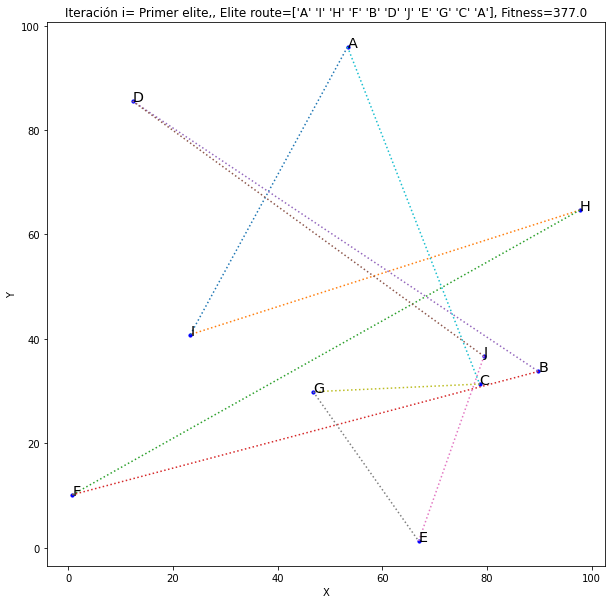

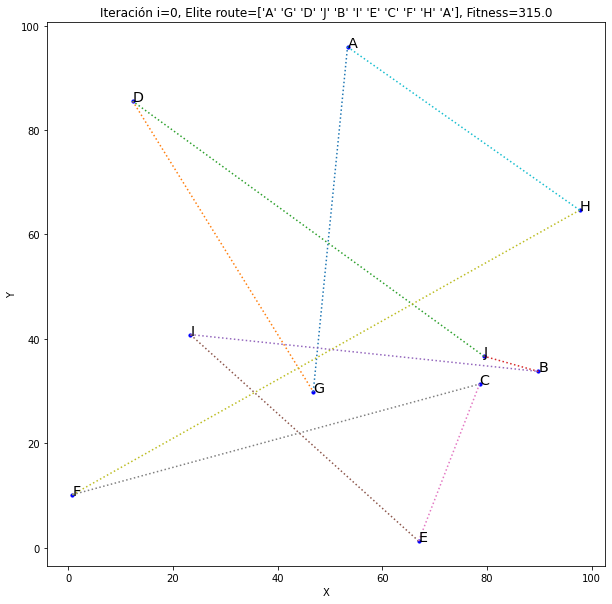

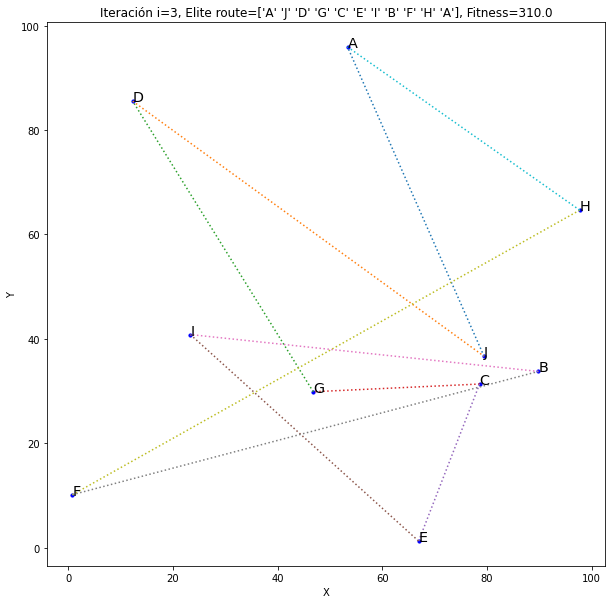

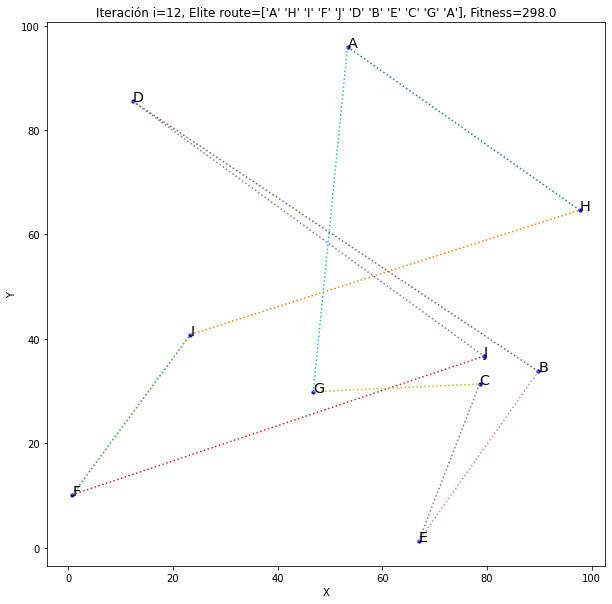

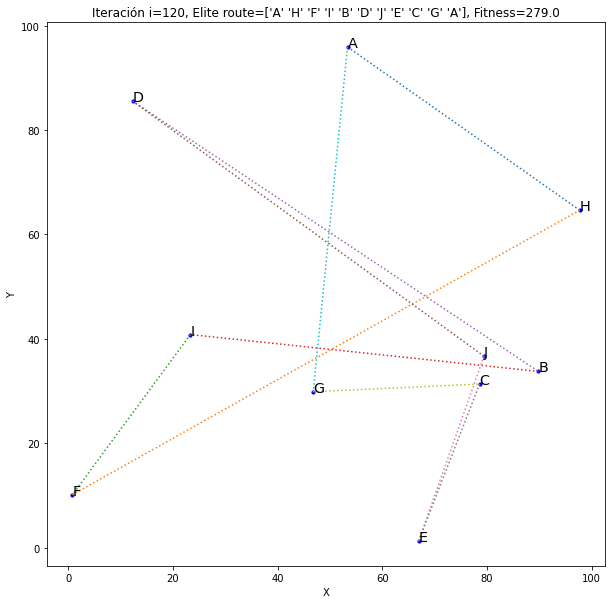

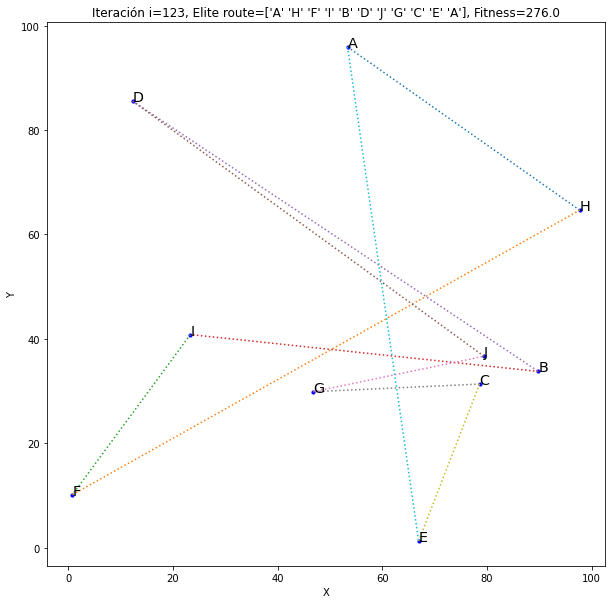

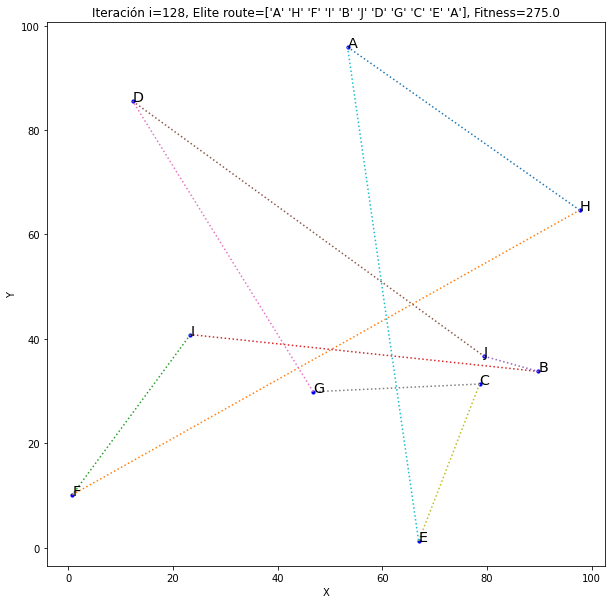

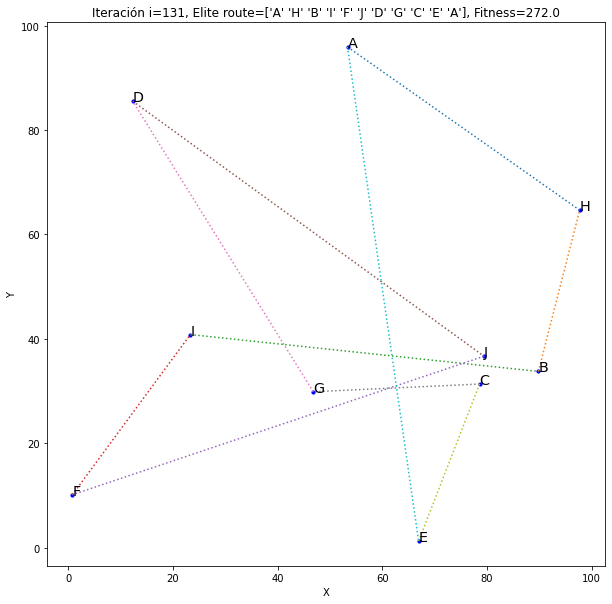

In [27]:
geneticAlgorithm(nodeNames, positionDict, distancesMatrix, nodePositions, 100, 1000, 0.8, 0.3)

### <br><br><br><br>Generate our own 'dataset'

In [43]:
# Variables para la generación de nodos.
n = 26
lim = [100,100]

# Generar nodos.
nodeNamesG, positionDictG, distancesMatrixG, nodePositionsG = generateNodes(n, lim)

# Impresiones.
print("\nNombre de los nodos:", nodeNamesG)
print("\nDiccionario de posiciones:", positionDictG)
print("\nMatriz de distancias:\n", distancesMatrixG)
print("\nPosiciones de los nodos:\n", nodePositionsG)


Nombre de los nodos: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Diccionario de posiciones: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

Matriz de distancias:
 [[ 0. 71. 50. 78. 21. 52. 63. 60. 94. 59. 72. 56. 74. 72. 89. 35. 54. 60.
  87. 83. 71. 60. 76. 33. 71. 55.]
 [71.  0. 44. 46. 52. 21. 53. 59. 25. 35.  5. 18. 41. 46. 19. 66. 57. 44.
  16. 12. 34. 53. 21. 45. 11. 63.]
 [50. 44.  0. 80. 31. 25. 16. 78. 58. 60. 47. 26. 74. 76. 62. 26. 14. 11.
  56. 52. 23. 74. 61. 47. 36. 78.]
 [78. 46. 80.  0. 68. 55. 94. 27. 63. 21. 41. 56.  5.  7. 45. 93. 93. 85.
  52. 52. 78. 22. 26. 46. 57. 35.]
 [21. 52. 31. 68.  0. 32. 45. 57. 74. 48. 53. 36. 64. 63. 70. 26. 38. 41.
  67. 63. 50. 55. 60. 24. 51. 55.]
 [52. 21. 25. 55. 32.  0.

### Resolve Own Dataset (aquí sí se deben ver unos contornos, ya que las coordenas sí corresponden con los nodos de forma específica)

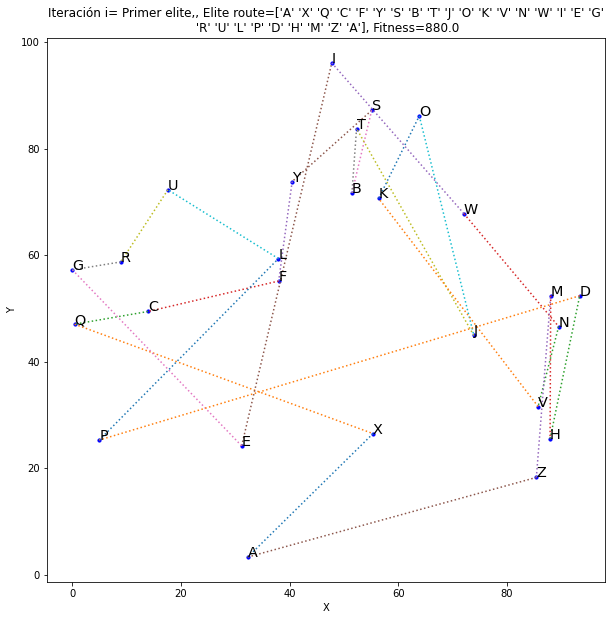

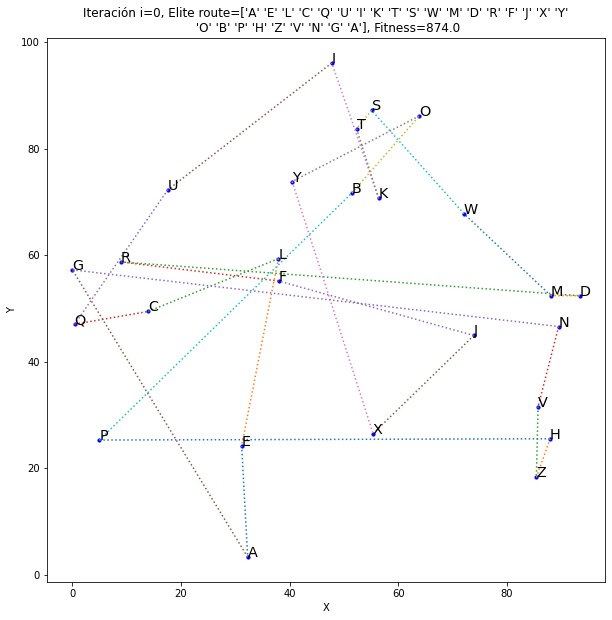

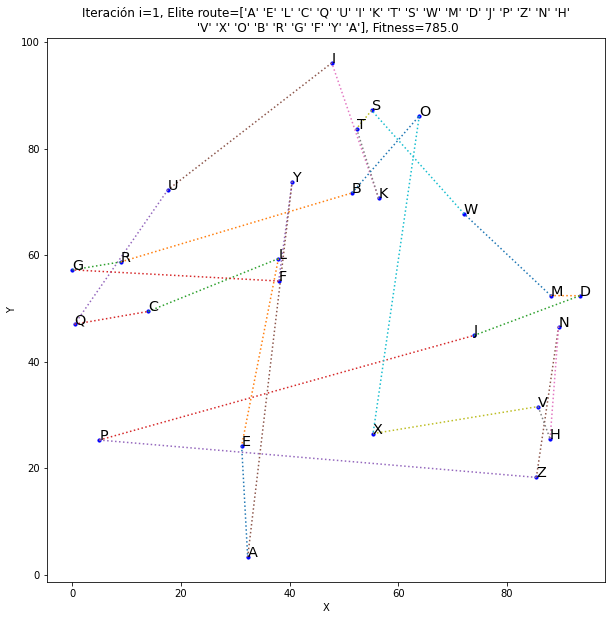

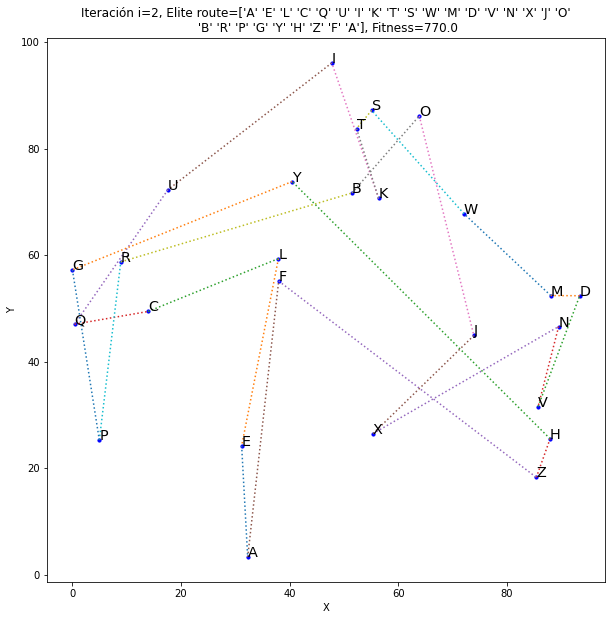

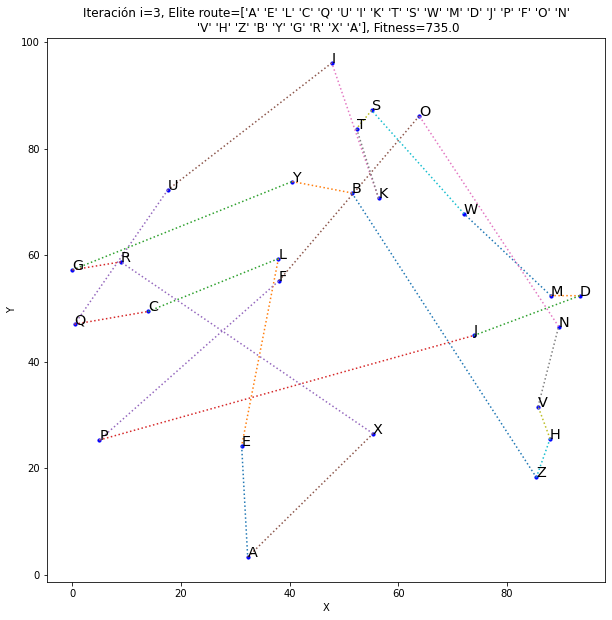

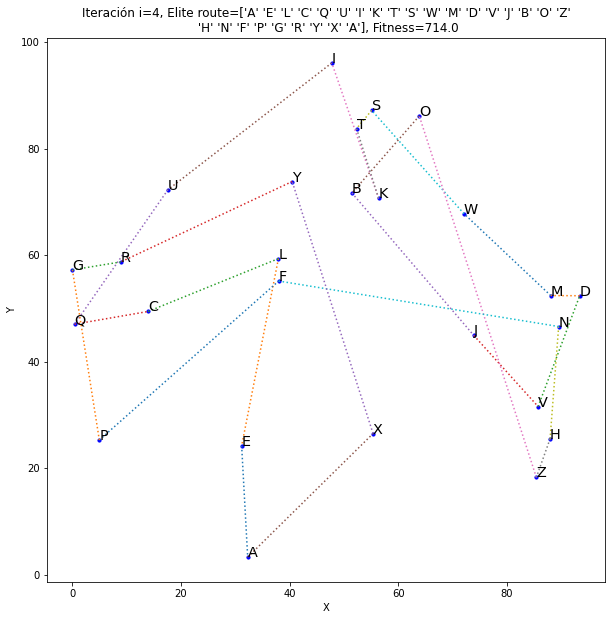

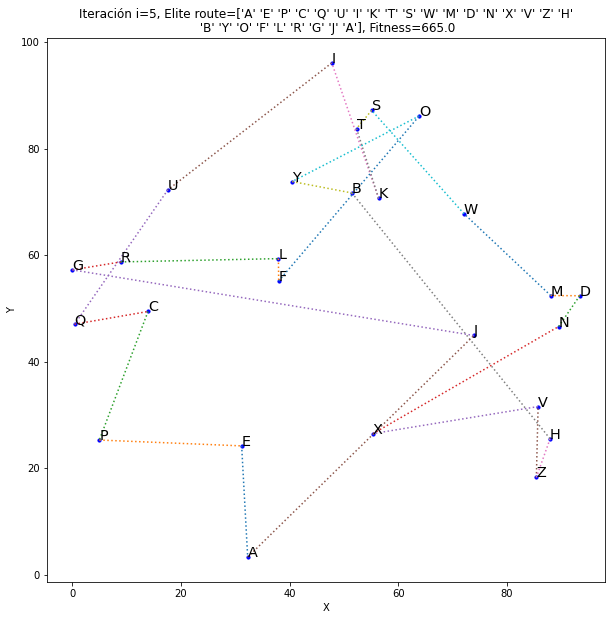

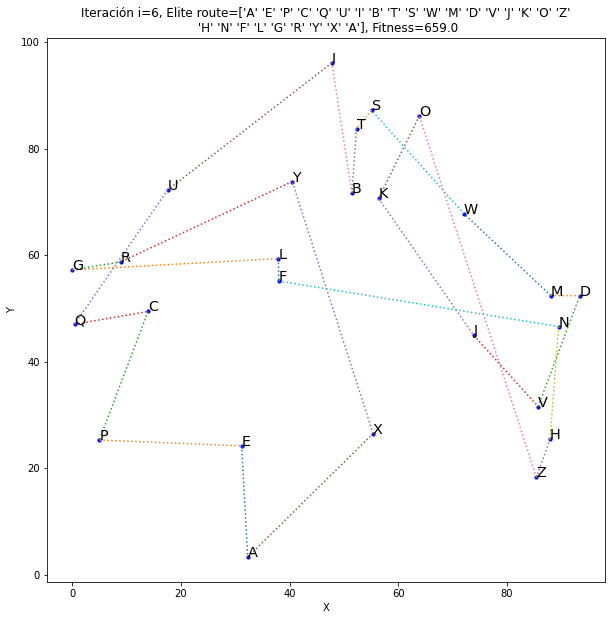

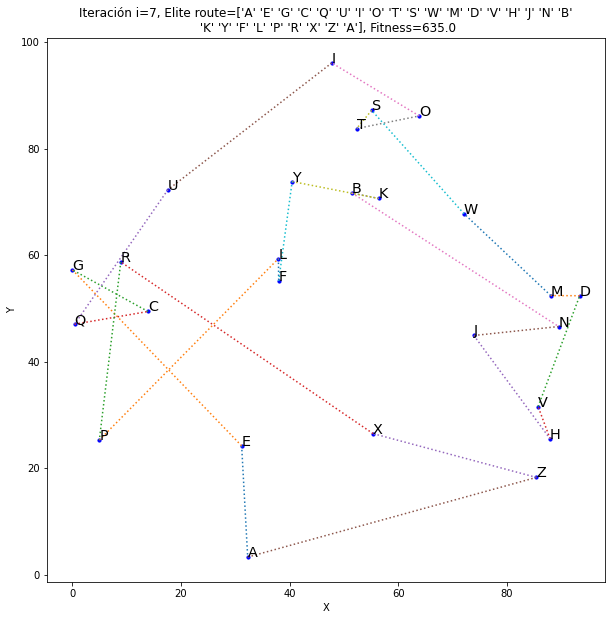

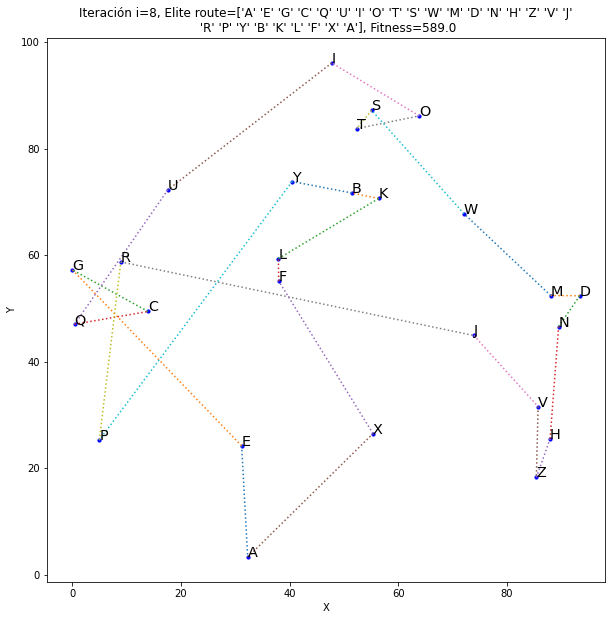

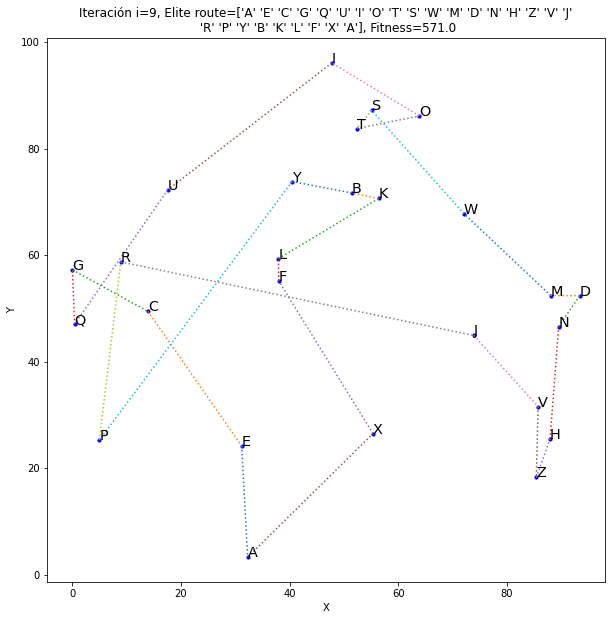

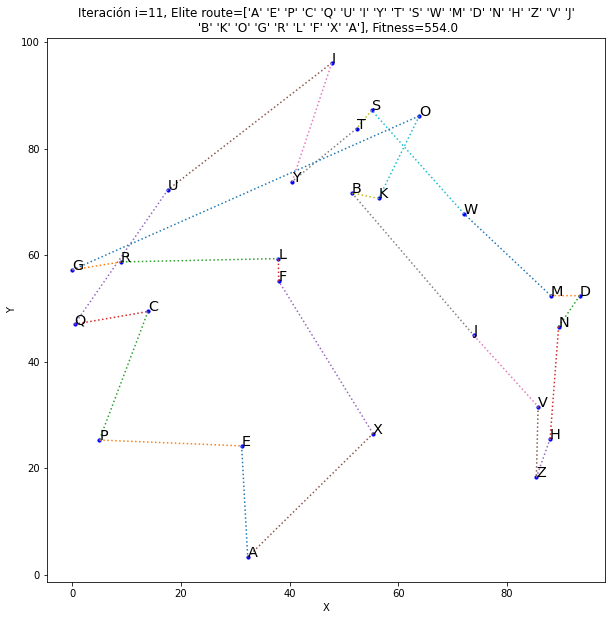

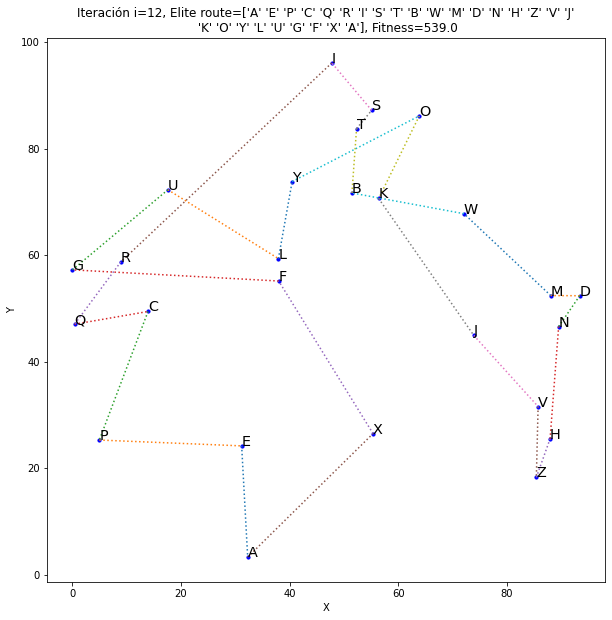

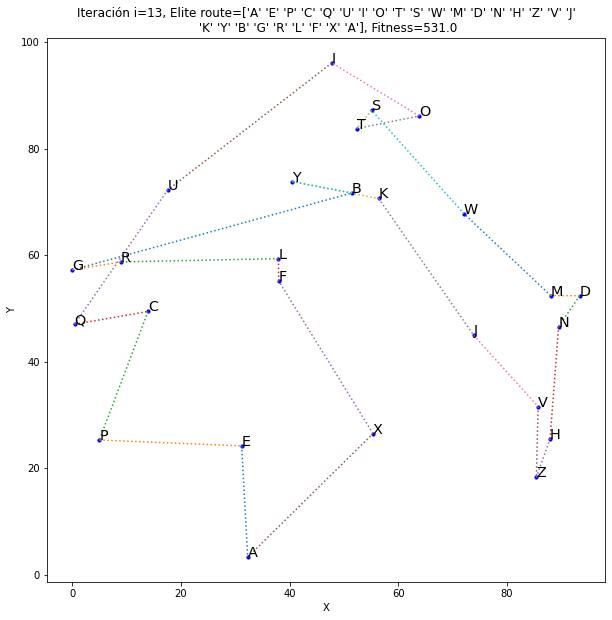

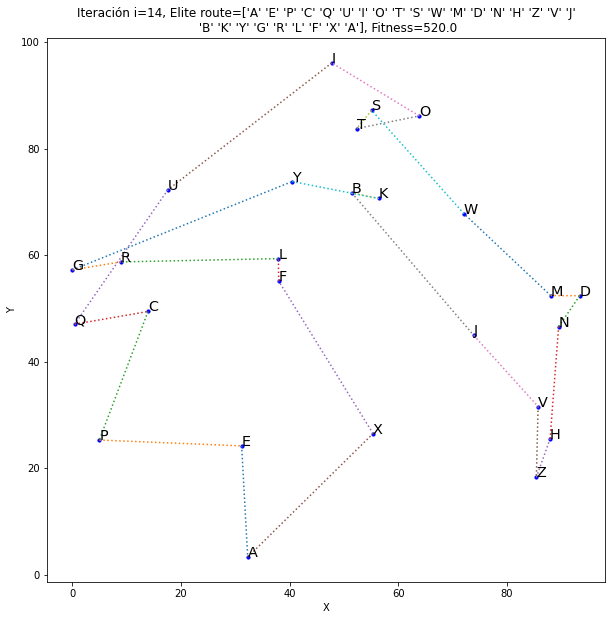

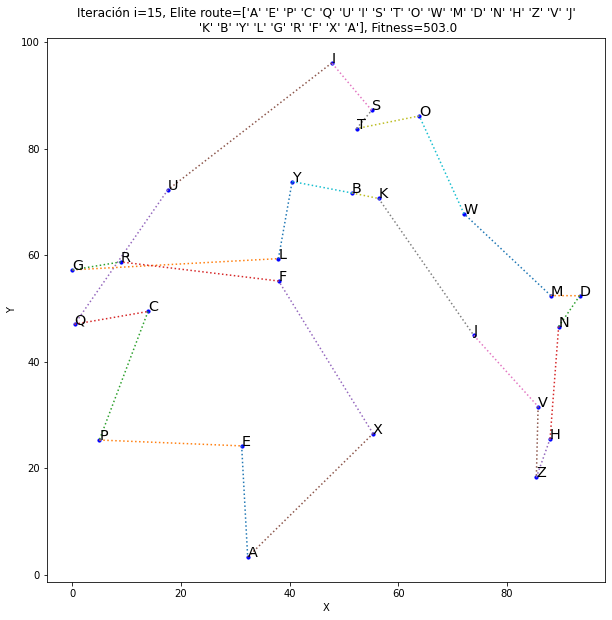

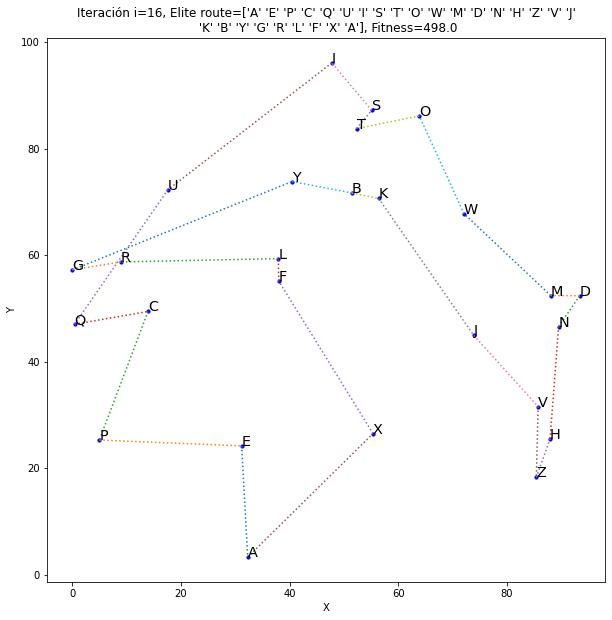

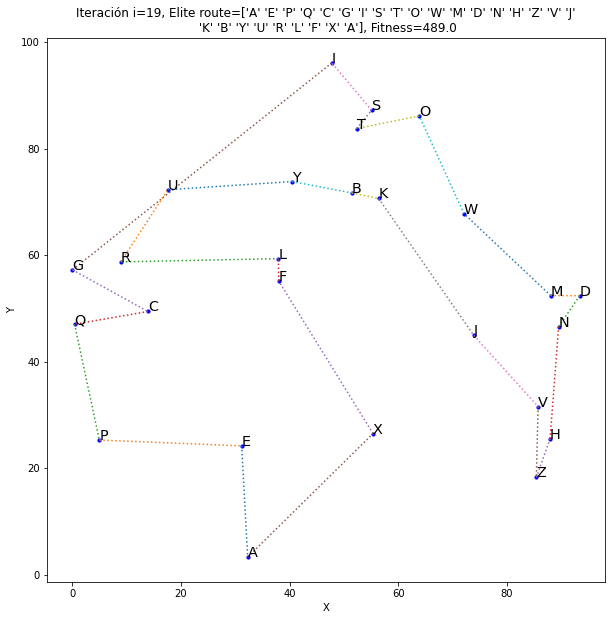

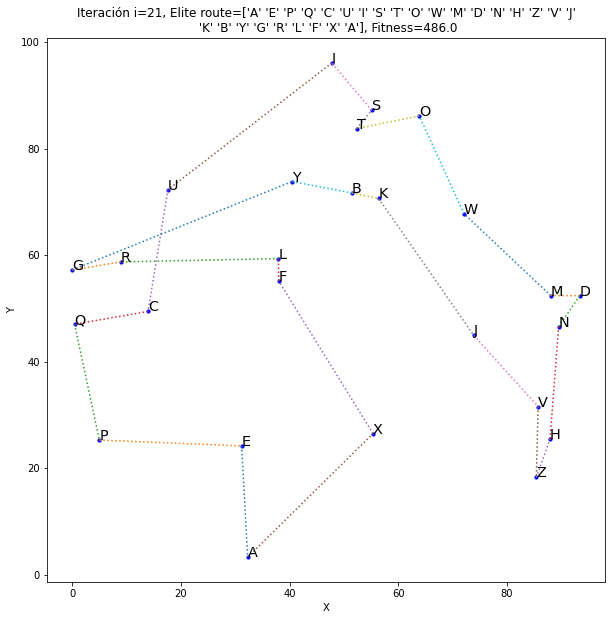

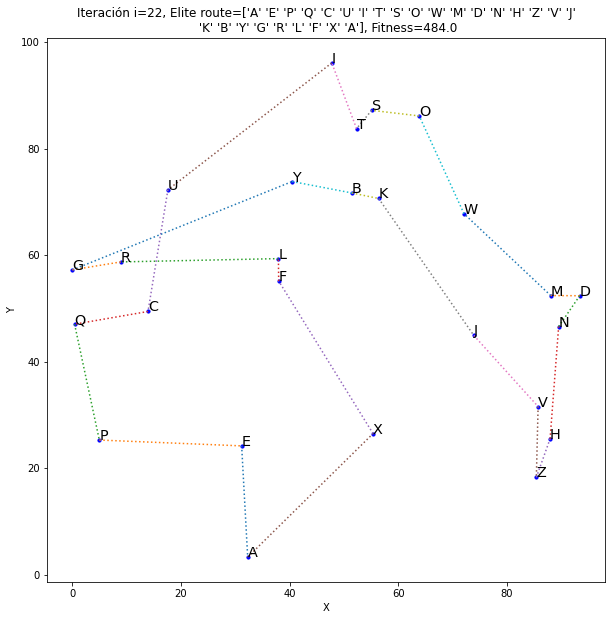

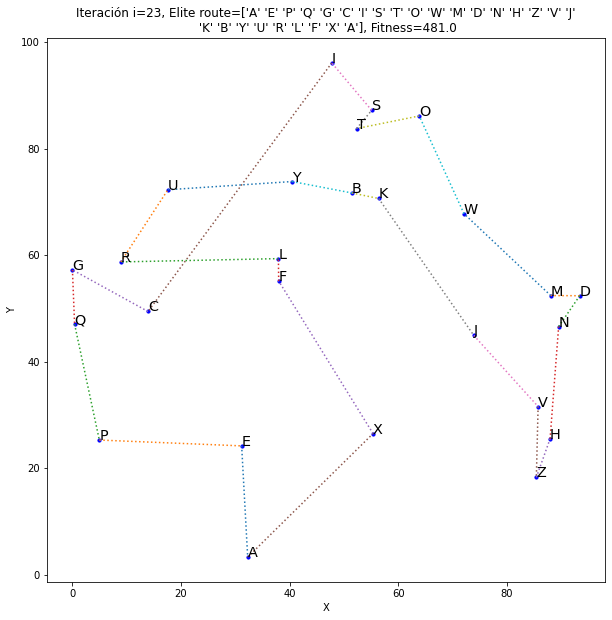

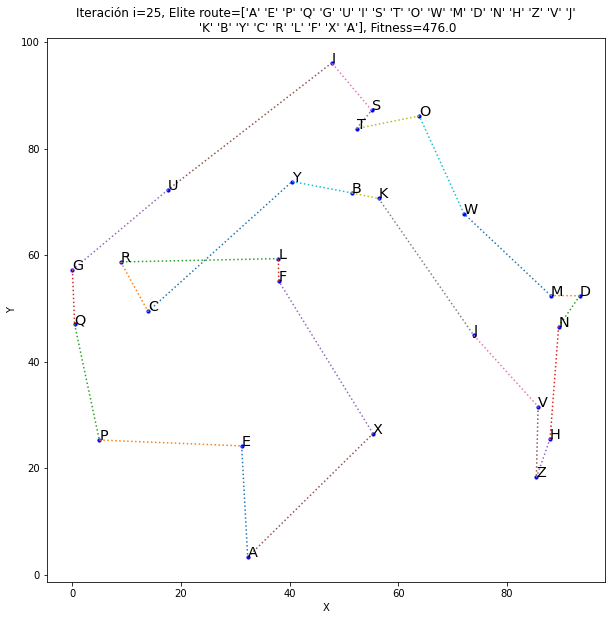

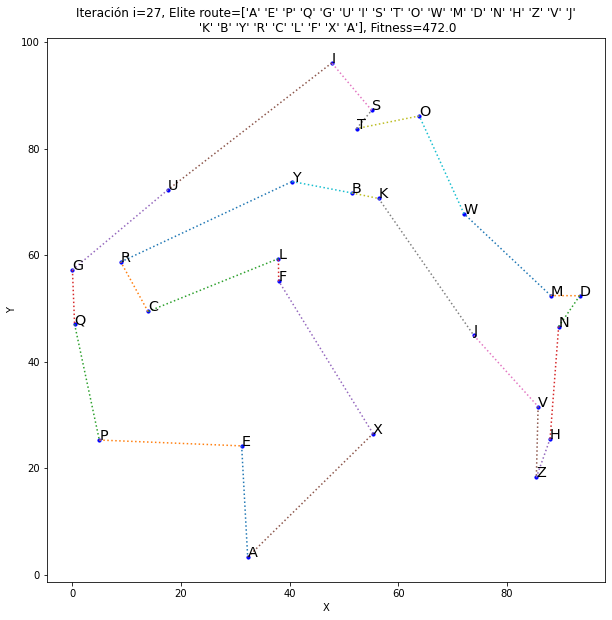

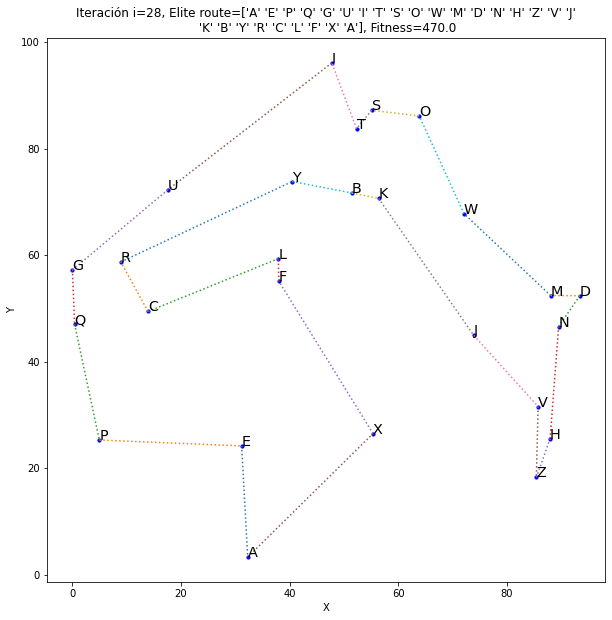

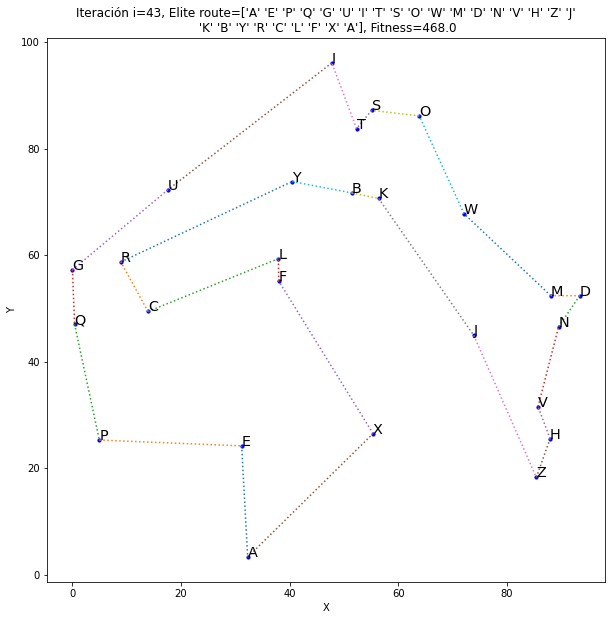

In [45]:
geneticAlgorithm(nodeNamesG, positionDictG, distancesMatrixG, nodePositionsG, 5000, 50, 0.8, 0.3)